# Moist Static Energy Difference Analysis
This notebook evaluates whether the assumption that the difference between the surface and free troposphere MSE, $\epsilon = h - h_{FT}$ varies as the climate warms in the same way for the mean summer day as the temperature percentile $x$ day.

I.e. it evaluates to what extent the assumption of $\delta \epsilon_x = \delta \overline{\epsilon}$ is valid.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm

2023-02-03 11:02:51,126 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [4]:
# Load dataset
exp_dir = 'tau_sweep/land/meridional_band/evap/'
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds += [isca_tools.load_dataset(exp_dir + exp_names[i])]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

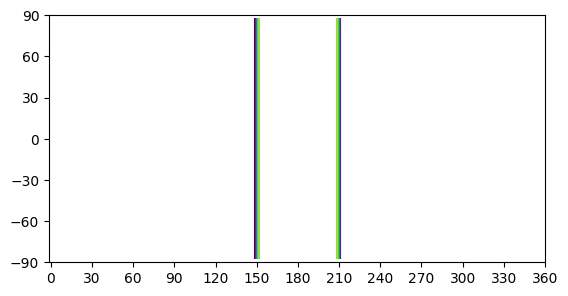

In [5]:
# Show where the land is
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
isca_tools.plot.show_land(land_file_name)

## Get datasets
Get one dataset, `ds_quant`, for tropics averaged over all days exceeding a given percentile in near surface air temperature.

Get another dataset, `ds_summer`, which is averaged over the summer.

In [6]:
## Split datasets into land and ocean ones
ds_all = {'land':[], 'ocean': []}
lon = {}
lon['land'] = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]
lon['ocean'] = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]
for i in range(n_exp):
    for surf in ['land', 'ocean']:
        ds_all[surf] += [ds[i].sel(lon=np.unique(lon[surf]), method='nearest')]

In [29]:
# Get data set averaged over all summer days in extratropics.
# Do this for each optical depth value
use_time_start = 360*2
# Tropics
lat_min = 0
lat_max = 20
# Extratropics
# lat_min = 30
# lat_max = 60

ds_summer = {'ocean': [], 'land': []}
for i in tqdm(range(n_exp)):
    for surf in ['ocean', 'land']:
        ds_use = ds_all[surf][i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
        ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [6, 7, 8]).sel(lat=slice(lat_min, lat_max))    # NH summer is JJA
        ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [12, 1, 2]).sel(lat=slice(-lat_max, -lat_min))    # SH summer is DJF
        # Combine hemispheres and average over longitude, time and latitude.
        ds_use = xr.concat([ds_nh_summer.mean(dim=('lon', 'time')), ds_sh_summer.mean(dim=('lon', 'time'))], dim='lat').mean(dim='lat')
        ds_summer[surf] += [ds_use]

100%|██████████| 7/7 [00:01<00:00,  4.10it/s]


In [24]:
# Get data set averaged over all days exceeding given quantile of near surface temperature in given latitude.
# Do this for each optical depth value and for land and ocean
quantiles_use = [90, 95, 99]
n_quant = len(quantiles_use)
temp_quant_av = np.zeros(n_exp)
ds_quant = {'ocean': [[] for _ in range(n_exp)], 'land': [[] for _ in range(n_exp)]}
for i in tqdm(range(n_exp)):
    for surf in ['ocean', 'land']:
        ds_use = ds_all[surf][i].sel(time=slice(use_time_start, np.inf))     # Only use after converged
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)    # Only latitude region
        # Collapse to single coordinate and then take quantile over it
        ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
        # quantile_thresh = np.quantile(ds_use.temp[-1].to_numpy(), quantile/100)
        for j in range(n_quant):
            quantile_thresh = ds_use.temp[-1].quantile(quantiles_use[j]/100, dim='lon_lat_time', keep_attrs=True)
            # Average each variable in data over days where near surface temperature exceeds this quantile
            ds_use2 = ds_use.where(ds_use.temp[-1]>=quantile_thresh).mean(dim='lon_lat_time', skipna=True)
            ds_quant[surf][i] += [ds_use2]


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


In [25]:
# Compute the surface and saturation free troposphere MSE for the mean day
pressure_ft = 700
def mse_ft(dataset):
    # Calculate free troposphere saturated MSE for a given dataset in kJ/kg
    ds_use = dataset.sel(pfull=pressure_ft, method='nearest')
    pressure_ft_actual = ds_use.pfull * 100     # This is the pressure level closest to pressure_ft
    mix_ratio_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(ds_use.temp), pressure_ft_actual)
    sphum_sat = mix_ratio_sat/(1+mix_ratio_sat)
    return moist_static_energy(ds_use.temp, sphum_sat, ds_use.height)

def mse_surface(dataset):
    return moist_static_energy(dataset.temp[-1], dataset.sphum[-1], dataset.height[-1])

temp_mean = {'ocean': np.zeros(n_exp), 'land': np.zeros(n_exp)}
mse_mean = {'ocean': np.zeros(n_exp), 'land': np.zeros(n_exp)}
mse_ft_mean = {'ocean': np.zeros(n_exp), 'land': np.zeros(n_exp)}

for i in tqdm(range(n_exp)):
    for surf in ['ocean', 'land']:
        temp_mean[surf][i] = ds_summer[surf][i].temp[-1]
        mse_mean[surf][i] = mse_surface(ds_summer[surf][i])
        mse_ft_mean[surf][i] = mse_ft(ds_summer[surf][i])

100%|██████████| 7/7 [01:22<00:00, 11.78s/it]


In [26]:
# Compute the surface and saturation free troposphere MSE for the quantile days
temp_quant = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}
mse_quant = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}
mse_ft_quant = {'ocean': np.zeros((n_exp, n_quant)), 'land': np.zeros((n_exp, n_quant))}

with tqdm(total=n_exp*n_quant*2, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_quant):
            for surf in ['ocean', 'land']:
                temp_quant[surf][i, j] = ds_quant[surf][i][j].temp[-1]
                mse_quant[surf][i, j] = mse_surface(ds_quant[surf][i][j])
                mse_ft_quant[surf][i, j] = mse_ft(ds_quant[surf][i][j])
                pbar.update(1)

100%|██████████| 42/42 [12:50<00:00, 18.34s/it]


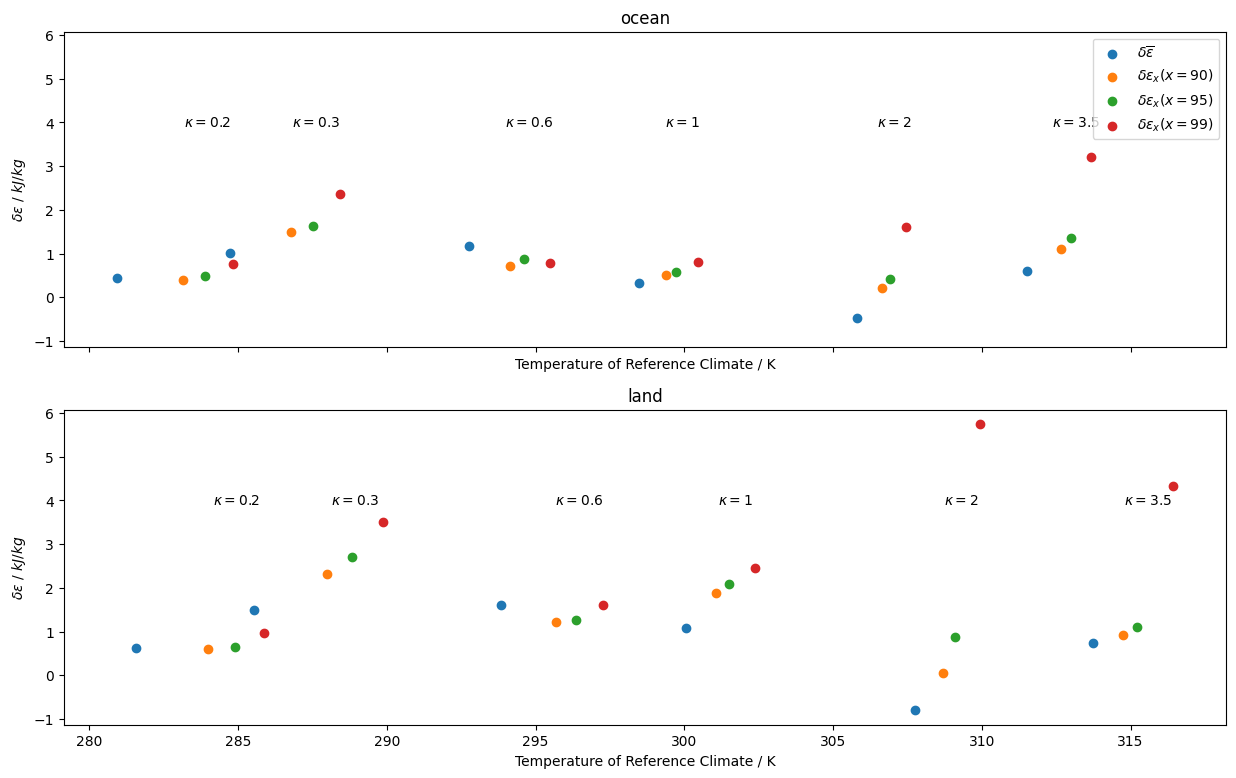

In [28]:
# Compute epsilon values indicating the difference between the surface MSE and free trop MSE
epsilon_mean = {'ocean': [], 'land': []}
epsilon_quant = {'ocean': [], 'land': []}
delta_epsilon_quant = {'ocean': [], 'land': []}
delta_epsilon_mean = {'ocean': [], 'land': []}
for surf in ['ocean', 'land']:
    epsilon_mean[surf] = mse_mean[surf] - mse_ft_mean[surf]
    epsilon_quant[surf] = mse_quant[surf] - mse_ft_quant[surf]
    delta_epsilon_quant[surf] = np.zeros((n_exp-1, n_quant))
    for j in range(n_quant):
        delta_epsilon_quant[surf][:, j] = np.ediff1d(epsilon_quant[surf][:, j])
    delta_epsilon_mean[surf] = np.ediff1d(epsilon_mean[surf])

fig, ax = plt.subplots(2,1, figsize=(15, 9), sharey=True, sharex=True)
for i, surf in enumerate(['ocean', 'land']):
    ax[i].scatter(temp_mean[surf][:-1], delta_epsilon_mean[surf], label='$\delta \overline{\epsilon}$')
    for j in range(n_quant):
        ax[i].scatter(temp_quant[surf][:-1, j], delta_epsilon_quant[surf][:, j], label=f'$\delta \epsilon_x(x={quantiles_use[j]})$')
    for k in range(n_exp-1):
        ax[i].text(np.mean([temp_quant[surf][k, 0], temp_quant[surf][k, -1]]), 4, f'$\kappa = {tau_lw[k]}$', ha='center', va='center')
    ax[i].set_xlabel('Temperature of Reference Climate / K')
    ax[i].set_ylabel('$\delta \epsilon$ / $kJ/kg$')
    ax[i].set_title(surf)
ax[0].legend();

### Tropics - $0 < |\phi| < 20$
From this plot, it seems that the assumption of $\delta \epsilon_x = \delta \overline{\epsilon}$ is approximately valid for the reference climate closest to Earth ($\kappa=1$) but not for any other climate.

Also, for the $\kappa=0.2, 0.3, 2, 3.5$ climates, there is a clear trend that $\delta \epsilon_x$ is larger than $\delta \overline{\epsilon}$ and increases with $x$.

The difference between land and ocean is less apparent as with the extratropics. Again though, the $\delta \epsilon_x = \delta \overline{\epsilon}$ assumption for $\kappa=1$ breaks down more over land than ocean.

### Extratropics - $30 < |\phi| < 60$
In the extratropics, it seems that $\delta \epsilon_x = \delta \overline{\epsilon}$ is approximately valid for the reference climate closest to Earth ($\kappa=1$).

For colder climates ($\kappa < 1$), it seems that $\delta \overline{\epsilon}$ is greater than $\delta \epsilon_x$ with the latter staying fairly constant as $x$ varies. These climates seem to show the same behaviour over land and ocean.

For warmer climates ($\kappa > 1$), it seems that $\delta \epsilon_x$ is larger than $\delta \overline{\epsilon}$ and increases with $x$. In terms of the difference between the mean and quantile $x$ days, the $\kappa=1$ climate over land resembles the $\kappa=2$ climate over ocean, so it does not satisfy $\delta \epsilon_x = \delta \overline{\epsilon}$. Equally, the $\kappa=2$ climate over land resembles the $\kappa=3.5$ climate over ocean, so there appears to be a systematic shift over land to over ocean.
